# Regression Algorithm: Golden Apple Price Prediction

The prices of Fresh Produce depend on a large number of factors which contribute to changes in the supply and demand. One of the factors that affect pricing is the amount of apples yielded in a season.

The main aim of this project is to develop a model that predicts prices of Golden Apples per kilogram in order for the Fresh Produce industry to meet its objectives. The industry aims to ensure there is adequate stock to cater for the demand of golden apples and simultaneously mitigate the amount of stock in hand to avoid any losses or waste. To achieve this, we will identify and collect data that is relevant to the past production and pricing of apples and build a regression algorithm that is able to forecast future golden apple prices.

<img src="Images/apples.jpg"
     style="float: center; padding-bottom=0.5em"
     width=600px/>
     

## Table of Contents
1. Variable Description
2. Loading Dependencies And Data
3. Data Cleaning
4. Explanatory Data Analysis
5. Feature Engineering
6. Variable Selection
7. Training Models
8. Model Selection
9. Conclusion
10. References

## Variable Description

This dataset consists of over 60 000 sales made by Durban Fresh Produce Market. Below is a description of Variable names used in the dataset:

- avg_price_per_kg - average price of the produce per kg (the response)
- Province - Which province the produce was grown
- Container - The code for the type of container
- Size_Grade - The class of the produce according to their quality
- Weight_Kg - The total weight in kilograms
- Commodities - The type of produce, e.g. Golden Delicious Apples
- Date - The date of the sale
- Sales_Total - The total sales price
- Total_Qty_Sold - The number of produce sold
- Total_Kg_Sold - The total weight of the produce sold in kilograms
- Stock_On_Hand - The amount of produce the store has

## Import Dependencies


In [490]:
#Visualisations

import matplotlib.pyplot as plt          
import seaborn as sns
sns.set(style='whitegrid')

#Data Wrangling
import pandas as pd
import numpy as np
import math
from scipy import stats

#Modelling
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score

import pickle


## Load Data


In [336]:
train = pd.read_csv('data/df - train_set.csv')
test = pd.read_csv('data/df - test_set.csv')
train = train[train.Commodities == 'APPLE GOLDEN DELICIOUS']
pd.options.display.max_columns = 100

## Data Cleaning
Before studying the dataframe we need to remove the Commodities Column as it contains one item "APPLE GOLDEN DELICIOUS"


In [337]:
train.drop("Commodities",inplace=True,axis=1)
test.drop("Commodities",inplace=True,axis=1)


Obtained the first 5 rows to get an idea of the type of data we are dealing with.

In [338]:
train.head()


,Province,Container,Size_Grade,Weight_Kg,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
1,CAPE,M4183,1L,18.3,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
7,CAPE,JG110,2M,11.0,2020-04-14,50.0,50.0,16000.0,320,3520.0,0,4.55
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,2020-04-16,55.0,55.0,990.0,18,162.0,1506,6.11
40,CAPE,M4183,1S,18.3,2020-05-04,80.0,120.0,32020.0,388,7100.4,443,4.51
69,EASTERN CAPE,IA400,1S,400.0,2020-09-28,1800.0,1800.0,1800.0,1,400.0,2,4.50


We studied the structure of our data. We retrieved the dimension, the various column names, their respective counts and data types. The data consist of 1952 rows and 12 columns. The columns consist of 8 numerical features, 3 categorical features and 1 date feature still in string format. The number of rows is the same as the number of values in each column so we can assume that the data does not contain any missing values.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 1 to 64310
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Province          1952 non-null   object 
 1   Container         1952 non-null   object 
 2   Size_Grade        1952 non-null   object 
 3   Weight_Kg         1952 non-null   float64
 4   Date              1952 non-null   object 
 5   Low_Price         1952 non-null   float64
 6   High_Price        1952 non-null   float64
 7   Sales_Total       1952 non-null   float64
 8   Total_Qty_Sold    1952 non-null   int64  
 9   Total_Kg_Sold     1952 non-null   float64
 10  Stock_On_Hand     1952 non-null   int64  
 11  avg_price_per_kg  1952 non-null   float64
dtypes: float64(6), int64(2), object(4)
memory usage: 198.2+ KB


We counted the number of unique values in each column.The data consists of 7 different provinces, 11 container types and 10 different size_grade. Furthermore we discovered that the data was collected over 147 different days

In [11]:
train.nunique()


Province               7
Container             11
Size_Grade            10
Weight_Kg              9
Date                 147
Low_Price             94
High_Price            88
Sales_Total         1324
Total_Qty_Sold       505
Total_Kg_Sold        850
Stock_On_Hand        735
avg_price_per_kg     601
dtype: int64

## **Exploratory Data Analysis**

### **Numerical Variables**

We obtained the summary statistics of all the numerical columns. From the table below, it is evident that all our independent numerical features are extremely skewed to the right. Their means are significantly higher than their mean. This indicates that more of the observations are to the left of the mean and that there are a couple of values to the extreme right. The response (avg_price_per_kg)

In [12]:
train.describe()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000
mean,40.460912,174.307377,215.648053,20053.533811,174.510758,2960.176332,408.393955,6.778893
std,99.655169,373.553578,433.546159,39005.069445,308.810797,6097.416527,724.450582,2.248744
min,3.000000,2.000000,5.000000,5.000000,1.000000,3.000000,0.000000,0.250000
25%,9.000000,50.000000,60.000000,1325.000000,12.000000,219.600000,9.000000,5.460000
50%,12.000000,80.000000,108.000000,5495.000000,64.000000,853.500000,126.500000,6.670000
75%,18.300000,127.250000,160.000000,21082.500000,200.000000,3093.525000,468.000000,8.280000
max,400.000000,2300.000000,3300.000000,369464.000000,4237.000000,74000.000000,6400.000000,21.240000


We measured the degree of skewness for each of our numerical variables. Skewness measures the degree of asymmetry in our data. Symmetric distributions have a near zero skewness. Distributions with a positive coefficient of skewness are said to be skewed to the right. The same is true about distributions with a negative value. A common measure of skewness is the  adjusted Fisher-Pearson coefficient of skewness and it is given by this formula:
$$skew=\frac{\sqrt{N\times(N-1)}}{N-2}\times\frac{\sum_{i=1}^{N} (Y_i-\bar{Y})^{3}}{s^3}$$


<img src="Images/skew1.jpg"
     style="float: center; padding-bottom=0.5em"
     width=600px/>

In [13]:
train.skew()

Weight_Kg           3.328254
Low_Price           4.222672
High_Price          3.828819
Sales_Total         4.250317
Total_Qty_Sold      4.445169
Total_Kg_Sold       5.529586
Stock_On_Hand       3.391815
avg_price_per_kg    0.082452
dtype: float64


Kurtosis is a measure that describes how heavily the tails of a distribution differ from the tails of a normal distribution. In other words, kurtosis identifies whether the tails of a given distribution contain extreme values. It is calculated by:

$$kurt=\frac{\sum_{i=1}^{N} (Y_i-\bar{Y})^{4}/N}{s^4}$$

The normal distribution has a kurtosis of 3, any distribution that has kurtosis of above 3 is said to be to have positive excess kurtosis (leptokurti) and indicates the presence of large outliers (heavy tails). Below 3, negative excess kurtosis 
(platykurtic) indicates light-tails.

From Our data we can see that our numerical explanatory have high kurtosis. The target variable (avg_price_per_kg) has negative excess kurtosis


In [9]:
train.kurtosis()

Weight_Kg            9.109698
Low_Price           17.073369
High_Price          13.630768
Sales_Total         24.200524
Total_Qty_Sold      32.338123
Total_Kg_Sold       45.153801
Stock_On_Hand       14.671224
avg_price_per_kg     1.042921
dtype: float64

We obtained the pairplots of all the numerical variables in our data set. We found that the target variable is follows a bell-like symmetrical distribution. The numerical explanatory variables are extremely skewed to the right. The low price and high price have a similar effect on average price (both increasing and following 2 paths). Sales_Total, Total_Qty_Sold, Total_Kg, Stock_On_Hand also displayed a near identical effect on average price. Furthermore we discovered that the Sales_Total and Total_Qty_Sold; and Low Price and High Price exhibit a linear increasing relationship which might be evidence of linear correlation

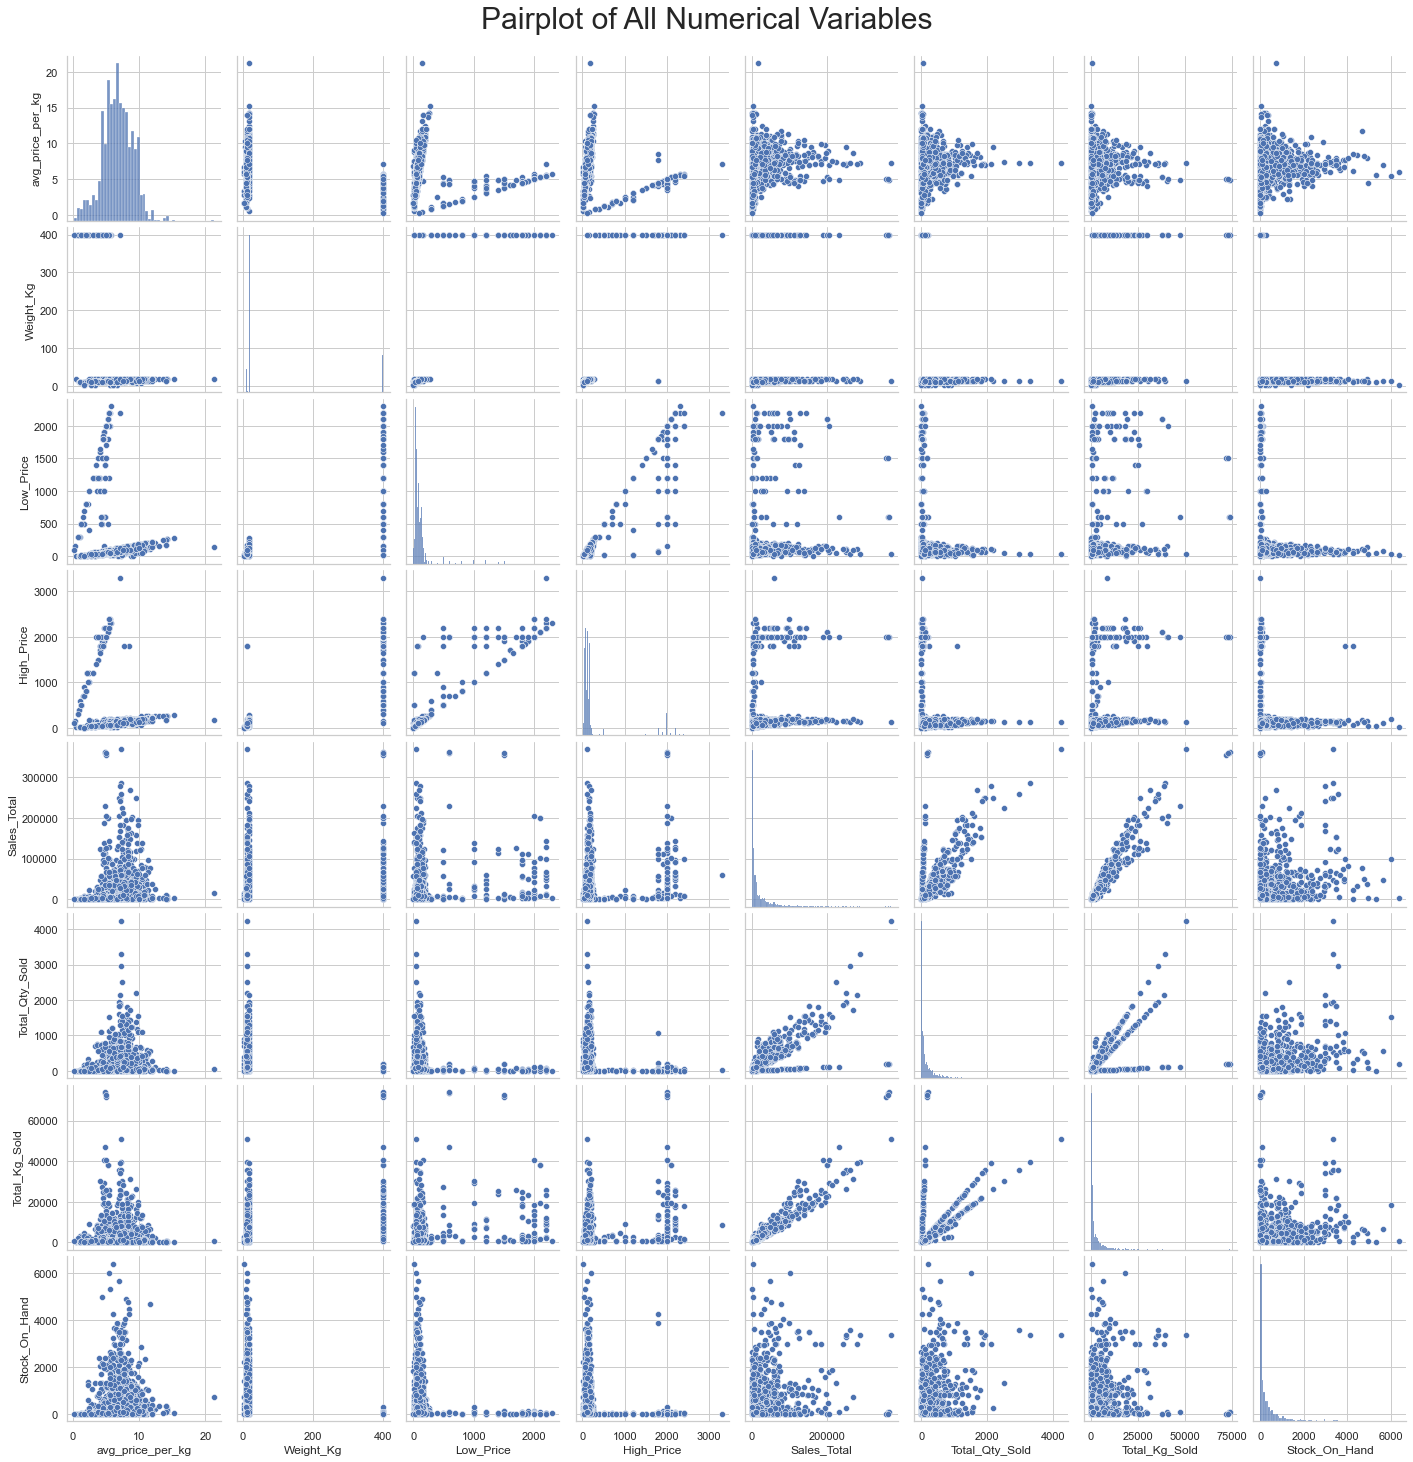

In [328]:
num_fil = ['avg_price_per_kg','Weight_Kg','Low_Price','High_Price','Sales_Total', \
           'Total_Qty_Sold','Total_Kg_Sold','Stock_On_Hand']

a = sns.pairplot(train[num_fil])
a.fig.suptitle("Pairplot of All Numerical Variables",y=1.02,fontsize='30')
plt.show()


We constructed a correlation heatmap for the numerical variables to check if any linear relationships exist between our response variables and independent features, and between the independent features themselves. We used the Pearson Correlation coefficient. It is a value between -1 and 1, with 1 representing  positive perfect correlation, -1 negative perfect correlation and 0 no correlation. It is given by this formula:
$$\rho_{i,j}=\frac{Cov(X_i,X_j)}{\sigma(X_i)\times\sigma(X_j)}$$
We found that the independent variables have a low correlation with the response variable. Furthermore we discovered Weight_kg,Low_Price,and High_Price are highly positively correlated. The Sales_Total and Total_kg_Sold are also highly correlated. 

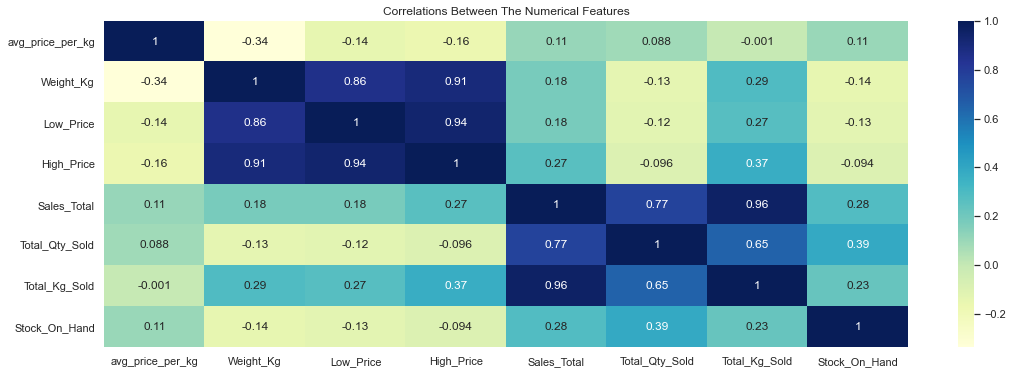

In [330]:
plt.figure(figsize = (18,6))
heat_map = sns.heatmap(train[num_fil].corr(),annot=True, cmap="YlGnBu")
heat_map.set_title('Correlations Between The Numerical Features')
plt.show()

### Date Variable

Now let us evaluate whether time has an effect on the average price of golden delicious apples. We plotted the average price per kg and its 7-day moving average against the date. Firstly we found that the average price varies from day-to-day. Secondly, we discovered that Golden Delicious Apples are generally more expensive the in the summer (December, January). Furthermore their prices generally decrease from the month of February up to the beginning of May when they start picking back up again. They finally reach a peak in the middle of June and then remain stable until October.

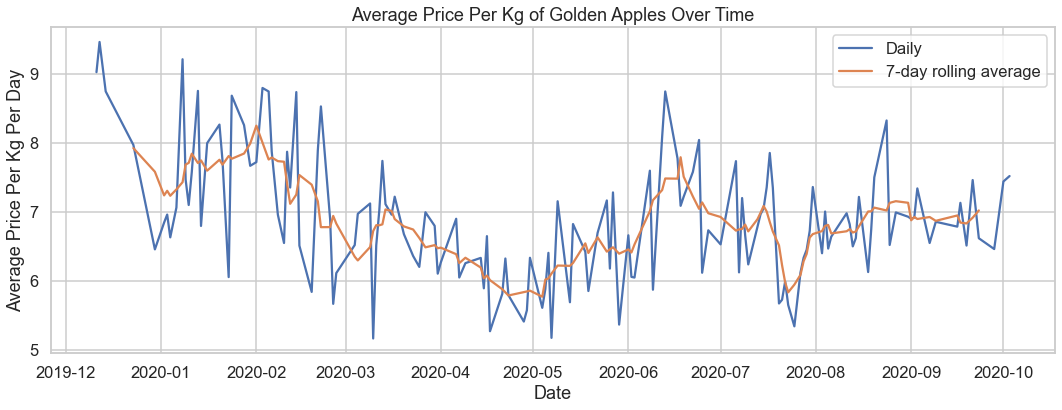

In [339]:
train['Date'] = pd.to_datetime(train['Date']) 

df_1 = train.groupby(['Date'], as_index=False)['avg_price_per_kg'].mean()
df_1["rolling_eve"]=df_1.avg_price_per_kg.rolling(7).mean().shift(-3)

sns.set_context("talk")
plt.figure(figsize=(18,6))
sns.lineplot(x="Date",y='avg_price_per_kg', label="Daily",data=df_1)
sns.lineplot(x="Date",y='rolling_eve', label="7-day rolling average",data=df_1)
plt.title('Average Price Per Kg of Golden Apples Over Time')
plt.ylabel('Average Price Per Kg Per Day')
plt.xlabel('Date')
plt.show()

<AxesSubplot:xlabel='year', ylabel='avg_price_per_kg'>

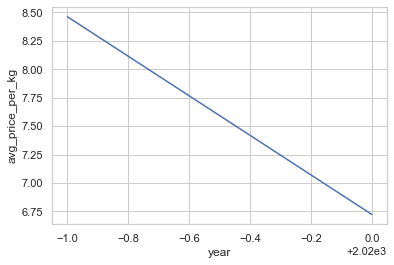

In [508]:

date_df = train.copy()

date_df['Month'] = train['Date'].dt.month
date_df['Day_of_Month']=train['Date'].dt.day
date_df['Day_of_Week']=train['Date'].dt.dayofweek
date_df['year']=train['Date'].dt.year


df_2=date_df.groupby(['Month'], as_index=False)['avg_price_per_kg'].mean()
df_3=date_df.groupby(['Day_of_Week'], as_index=False)['avg_price_per_kg'].mean()
df_4=date_df.groupby(['Day_of_Month'], as_index=False)['avg_price_per_kg'].mean()
df_5=date_df.groupby(['year'], as_index=False)['avg_price_per_kg'].mean()


sns.lineplot(x="year",y='avg_price_per_kg',data=df_5)


## **Categorical Variables**

We plotted the count of each category
Most of the apples are produced in the CAPE region. Orange Free state produced the least number of apples. 

1S size_grade is the most produced


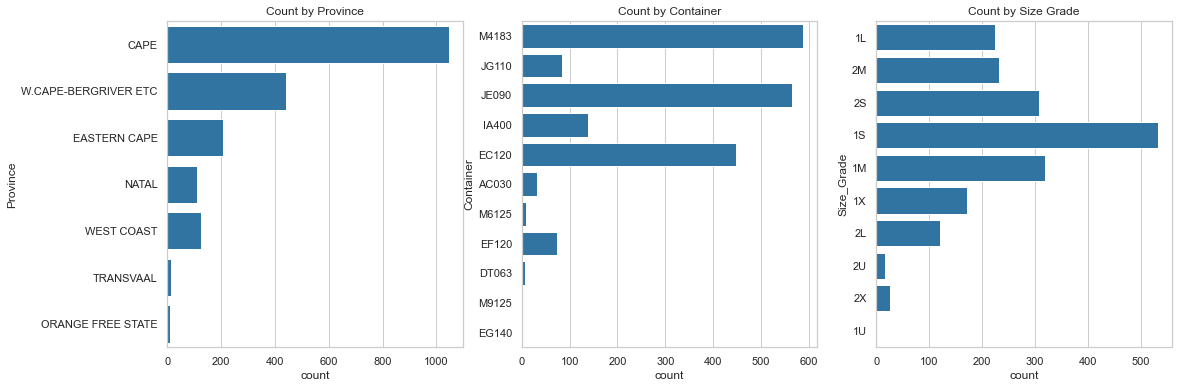

In [107]:
fig, axs = plt.subplots(1,3, figsize=(18, 6))

cp1 = sns.countplot(y = 'Province',data = train, ax=axs[0],color='#1f77b4')
cp2 = sns.countplot(y = 'Container', ax=axs[1],data = train,color='#1f77b4')
cp3 = sns.countplot(y = 'Size_Grade', ax=axs[2],data = train,color='#1f77b4')
cp1.set_title("Count by Province")
cp2.set_title("Count by Container")
cp3.set_title("Count by Size Grade")

plt.show()


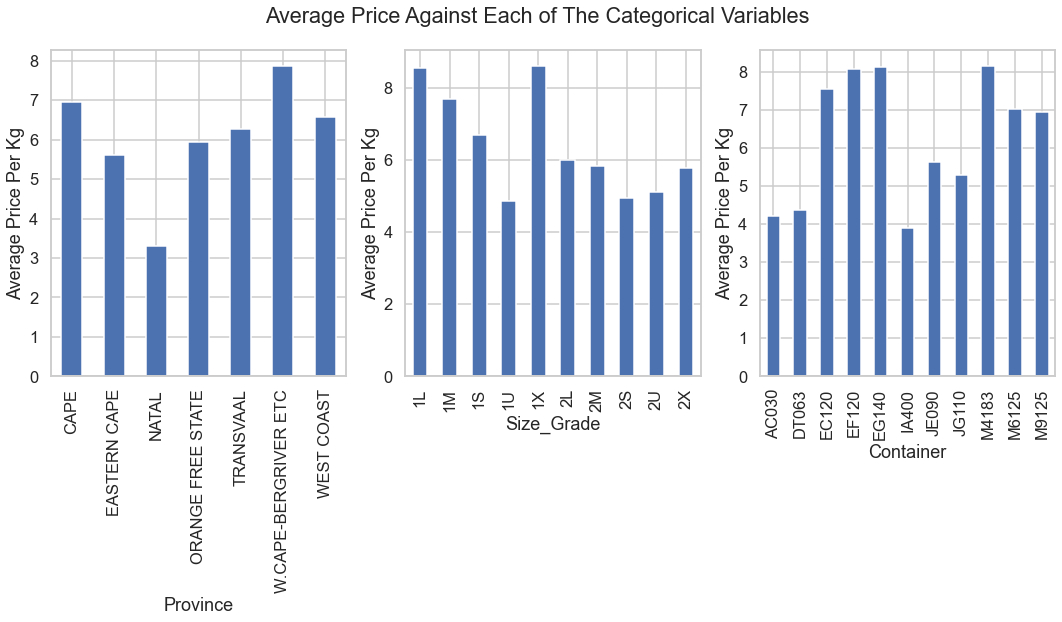

In [25]:
fig, axs = plt.subplots(1,3, figsize=(18, 6))

gb1 = train.groupby(train['Province'])['avg_price_per_kg'].mean().plot(kind='bar', ax=axs[0])
gb2 = train.groupby(train['Size_Grade'])['avg_price_per_kg'].mean().plot(kind='bar',ax=axs[1])
gb3 = train.groupby(train['Container'])['avg_price_per_kg'].mean().plot(kind='bar',ax=axs[2])

gb1.set_ylabel("Average Price Per Kg")
gb2.set_ylabel("Average Price Per Kg")
gb3.set_ylabel("Average Price Per Kg")

fig.suptitle('Average Price Against Each of The Categorical Variables')
plt.show()


## **Feature Engineering**


Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms.

In [509]:
X_df = train.drop(['avg_price_per_kg'],axis = 1)
y_df= train['avg_price_per_kg']

In [510]:
X_df.head()

,Province,Container,Size_Grade,Weight_Kg,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand
1,CAPE,M4183,1L,18.3,2020-09-09,150.0,170.0,51710.0,332,6075.6,822
7,CAPE,JG110,2M,11.0,2020-04-14,50.0,50.0,16000.0,320,3520.0,0
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,2020-04-16,55.0,55.0,990.0,18,162.0,1506
40,CAPE,M4183,1S,18.3,2020-05-04,80.0,120.0,32020.0,388,7100.4,443
69,EASTERN CAPE,IA400,1S,400.0,2020-09-28,1800.0,1800.0,1800.0,1,400.0,2


In [511]:
test.head()


,Index,Province,Container,Size_Grade,Weight_Kg,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand
0,1,W.CAPE-BERGRIVER ETC,EC120,1M,12.0,2020-07-09,128.0,136.0,5008.0,38,456.0,0
1,2,W.CAPE-BERGRIVER ETC,M4183,1X,18.3,2020-01-20,220.0,220.0,1760.0,8,146.4,2
2,3,W.CAPE-BERGRIVER ETC,EC120,1S,12.0,2020-08-19,120.0,120.0,720.0,6,72.0,45
3,4,W.CAPE-BERGRIVER ETC,M4183,1M,18.3,2020-05-06,160.0,160.0,160.0,1,18.3,8
4,5,W.CAPE-BERGRIVER ETC,M4183,1L,18.3,2020-05-04,140.0,160.0,14140.0,100,1830.0,19


### Extracting Date Features

In [512]:
X_df['Year'] = X_df['Date'].dt.year
X_df['Month'] = X_df['Date'].dt.month_name()
X_df['Day_of_Month'] = X_df['Date'].dt.day
X_df['Day_of_Week'] = X_df['Date'].dt.day_name()
X_df.drop(['Date'],axis = 1, inplace = True)
X_df.head()

,Province,Container,Size_Grade,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Year,Month,Day_of_Month,Day_of_Week
1,CAPE,M4183,1L,18.3,150.0,170.0,51710.0,332,6075.6,822,2020,September,9,Wednesday
7,CAPE,JG110,2M,11.0,50.0,50.0,16000.0,320,3520.0,0,2020,April,14,Tuesday
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,55.0,55.0,990.0,18,162.0,1506,2020,April,16,Thursday
40,CAPE,M4183,1S,18.3,80.0,120.0,32020.0,388,7100.4,443,2020,May,4,Monday
69,EASTERN CAPE,IA400,1S,400.0,1800.0,1800.0,1800.0,1,400.0,2,2020,September,28,Monday


In [513]:
test_df = test.copy()
test_df['Date'] = pd.to_datetime(test['Date'])
test_df['Year'] = test_df['Date'].dt.year
test_df['Month'] = test_df['Date'].dt.month_name()
test_df['Day_of_Month'] = test_df['Date'].dt.day
test_df['Day_of_Week'] = test_df['Date'].dt.day_name()
test_df.drop(['Date','Index'],axis = 1, inplace = True)
test_df.head()
 

,Province,Container,Size_Grade,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Year,Month,Day_of_Month,Day_of_Week
0,W.CAPE-BERGRIVER ETC,EC120,1M,12.0,128.0,136.0,5008.0,38,456.0,0,2020,July,9,Thursday
1,W.CAPE-BERGRIVER ETC,M4183,1X,18.3,220.0,220.0,1760.0,8,146.4,2,2020,January,20,Monday
2,W.CAPE-BERGRIVER ETC,EC120,1S,12.0,120.0,120.0,720.0,6,72.0,45,2020,August,19,Wednesday
3,W.CAPE-BERGRIVER ETC,M4183,1M,18.3,160.0,160.0,160.0,1,18.3,8,2020,May,6,Wednesday
4,W.CAPE-BERGRIVER ETC,M4183,1L,18.3,140.0,160.0,14140.0,100,1830.0,19,2020,May,4,Monday


### Encoding Categorical Variables


Machine learning models requires all input and output variables to be numeric. This means that if your data contains categorical data, you must encode it to numbers before you can fit and evaluate a model. **get_dummies()** is used for data manipulation. It converts categorical data into dummy or indicator variables.

<img src="Images/Encoding_example.jpeg"
     style="float: center; padding-bottom=0.5em"
     width=600px/>

In [648]:
X_df = pd.get_dummies(X_df,drop_first=True)
X_df.columns = [col.replace(" ","_") for col in X_df.columns]

test_df = pd.get_dummies(test_df,drop_first=True)
test_df.columns = [col.replace(" ","_") for col in test_df.columns]

In [649]:
X_df.shape


(1952, 49)

In [650]:
test_df.shape


(685, 49)

## Variable Selection


In [641]:
corrs = zip(X_df,y_df).corr()['avg_price_per_kg'].sort_values(ascending=False)


AttributeError: 'zip' object has no attribute 'corr'

In [451]:
dict_cp = {}

column_titles = [col for col in corrs.index if col!= 'avg_price_per_kg']
for col in column_titles:
    p_val = round(pearsonr(df_train[col], df_train['avg_price_per_kg'])[1],6)
    dict_cp[col] = {'Correlation_Coefficient':corrs[col],
                    'P_Value':p_val}

df_cp = pd.DataFrame(dict_cp).T
df_cp_sorted = df_cp.sort_values('P_Value')
df_cp_sorted

,Correlation_Coefficient,P_Value
Sales_Total,0.108473,0.000000
Low_Price,-0.141740,0.000000
High_Price,-0.164496,0.000000
Weight_Kg,-0.337886,0.000000
Stock_On_Hand,0.105028,0.000003
Total_Qty_Sold,0.087536,0.000108
Total_Kg_Sold,-0.001007,0.018447


## Train-Validation Split

In [651]:

X=X_df.values #taking everything besides the last column

y=y_df.values #the response


In [652]:

X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2, random_state=1)

In [653]:
X_test=test_df.values

## Feature Scaling
There are two widely used scaling techniques: Standardisation and Min-Mix Normalisation. Standardisation rescales the data points to ensure that our data has a mean of 0 and a standard deviation of 1. Using the following equation
$$x_{stand}=\frac{x-\mu}{\sigma}$$
Min-Max Normalisation maps all the points to the [0,1] interval using this equation
$$x_{norm}=\frac{x-\min{(x)}}{\max{(x)}-\min{(x)}}$$
Since our data is skewed, we opted for the standardisation since it has been shown in the past to be more robust to outliers>


In [654]:
sc_X = StandardScaler()
X_train_stand = sc_X.fit_transform(X_train)

X_val_stand = sc_X.transform(X_val)

X_test_stand =sc_X.transform(X_test)


## Model Training   

### Evaluation Metric

Root Mean Squared Error (RMSE) is a measure of fit that is derived from the average squared distance between the actual value of the target variable and predicted value. Lower RMSE implies a better fit

$$\text{RMSE}=\sqrt{\frac{\sum_{i}^{N}(y-\hat{y})^2}{N}}$$


### Model 1 : Multiple Linear Regression

Multiple linear regression allows you to model the relationship between a the response variable and a set of explanatory variable(s) by fitting a line/hyperplane that minimizes the squared distance between itself and our observations. It is given by the following formula:
$$y_i=\beta_0+\beta_1x_{i1}+\beta_2x_{i2}+...+\beta_{k}x_{ik}+e_i$$
Where:
* Y  is the reponse variable which depends on the  p  predictor variables;
* β0  is the intercept, interpreted as the value of  Y  when all predictor variables are equal to zero;
* βj  is the average effect on  Y  of a one unit increase in  Xj , assuming all other predictors are held fixed.

Assumptions:

Regression residuals must be normally distributed.

A linear relationship is assumed between the dependent variable and the independent variables.

The residuals are homoscedastic and approximately rectangular-shaped.

Absence of multicollinearity is assumed in the model, meaning that the independent variables are not too highly correlated.

In [657]:

#Fitting a basic linear Model
lm=LinearRegression()
lm.fit(X_train_stand,y_train)

LinearRegression()

#### Model 1 Performance

In [658]:
y_train_pred1 = lm.predict(X_train_stand)
y_val_pred1 = lm.predict(X_val_stand)


In [659]:
MRSStrain1 = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred1))
MRSSval1 = np.sqrt(metrics.mean_squared_error(y_val, y_val_pred1))
print('The training Root Mean Squared Error is:',MRSStrain1,'.The validation Root Mean Squared Error is:',MRSSval1)

The training Root Mean Squared Error is: 1.3546573222618843 .The validation Root Mean Squared Error is: 1.1974455248538876


#### Model 1 Prediction

In [660]:
y_pred1 =lm.predict(X_test)

In [876]:
submission = pd.DataFrame({'Index': test.Index, 'avg_price_per_kg': y_pred1})

In [877]:
submission.head()


,Index,avg_price_per_kg
0,1,8.823697
1,2,8.921020
2,3,8.506357
3,4,8.651164
4,5,8.335139


In [487]:
submission.to_csv(r'C:\Users\nknhl\OneDrive\Documents\GitHub\Team_7_regression\2nd_submission.csv', index = False)


### Model 2:  Ridge Regression
Ridge regression is a method for analysining multiple regression data that suffers from multicollinearity. When multicollinearity exists our estimates are unbiased but their variance is high and hence produce unrelable results. It is used as a method for reducing overfitting, producing better out-sample predictions than the standard method> We introduce a penalty term to our RSS calculations. Now our objective is to minimize this:


$$\text{Objective} = \min_{\beta}\left(\sum_{i=1}^n(y_i-(a+\sum_{j=1}^p\beta_jx_{ij}))^2 + \alpha\sum_{j=1}^p\beta_j^2\right)$$

Which can be written as:
$$\text{Objective} = \min_{\beta} \left(RSS + \alpha\sum_{j=1}^p\beta_j^2\right)$$




In [525]:
ridge = Ridge()
ridge.fit(X_train_stand,y_train)

Ridge()

#### Model 2 Performance

In [526]:
y_train_pred2 = ridge.predict(X_train_stand)
y_val_pred2 = ridge.predict(X_val_stand)

In [527]:
MRSStrain2 = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred2))
MRSSval2 = np.sqrt(metrics.mean_squared_error(y_val, y_val_pred2))
print('The training Root Mean Squared Error is:',MRSStrain2,'.The validation Root Mean Squared Error is:',MRSSval2)

The training Root Mean Squared Error is: 1.406400059133835 .The validation Root Mean Squared Error is: 1.2499934994483535


#### Model 2 Prediction

In [881]:
y_pred2 = ridge.predict(X_test)

#y_pred2=list(np.concatenate(sc_y.inverse_transform(y_pred2)).flat)


In [882]:

submission2 = pd.DataFrame({'Index': test.Index, 'avg_price_per_kg': y_pred2})
submission2.head()

,Index,avg_price_per_kg
0,1,8.847641
1,2,8.917163
2,3,8.508041
3,4,8.667651
4,5,8.327164


In [621]:
submission.to_csv(r'C:\Users\nknhl\OneDrive\Documents\GitHub\Team_7_regression\ridge_submission.csv', index = False)

### Model 3: Lasso Regression

Lasso (Least Absolute Shrinkage and Selection Operator) regression is a type of linear regression that uses shrinkage. Shrinkage is where data values are shrunk towards a central point, like the mean. The lasso procedure encourages simple, sparse models (i.e. models with fewer parameters). This particular type of regression is well-suited for models showing high levels of muticollinearity or when you want to automate certain parts of model selection, like variable selection/parameter elimination.

Lasso regression performs L1 regularization, which adds a penalty equal to the absolute value of the magnitude of coefficients. This type of regularization can result in sparse models with few coefficients; Some coefficients can become zero and eliminated from the model. Larger penalties result in coefficient values closer to zero, which is the ideal for producing simpler models.

$$\text{Objective} = \min_{\beta}\left(\sum_{i=1}^n(y_i-(a+\sum_{j=1}^p\beta_jx_{ij}))^2 + \alpha\sum_{j=1}^p|\beta_j|\right)$$
which can be rewritten as:
$$\text{Objective} = \min_{\beta} \left(RSS + \alpha\sum_{j=1}^p|\beta_j|\right)$$

In [528]:
lasso=Lasso()
lasso.fit(X_train_stand,y_train)

Lasso()

#### Model 3 Performance

In [529]:
y_train_pred3 = lasso.predict(X_train_stand)
y_val_pred3 = lasso.predict(X_val_stand)

In [530]:
MRSStrain3 = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred3))
MRSSval3 = np.sqrt(metrics.mean_squared_error(y_val, y_val_pred3))
print('The training Root Mean Squared Error is:',MRSStrain3,'.The validation Root Mean Squared Error is:',MRSSval3)

The training Root Mean Squared Error is: 2.280609628875136 .The validation Root Mean Squared Error is: 2.114026364281998


### Model 4: Support Vector Regression

In [469]:
svr = SVR()
svr.fit(X_train_stand,y_train)

SVR()

#### Model 4 Performance

In [471]:
y_train_pred4 = svr.predict(X_train_stand)
y_val_pred4 = svr.predict(X_val_stand)

In [472]:
MRSStrain4 = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred4))
MRSSval4 = np.sqrt(metrics.mean_squared_error(y_val, y_val_pred4))
print('The training Root Mean Squared Error is:',MRSStrain4,'.The validation Root Mean Squared Error is:',MRSSval4)

The training Root Mean Squared Error is: 1.1596808338746143 .The validation Root Mean Squared Error is: 1.0837133957455156


### Model 5: Decision Tree

In [473]:
regr_tree = DecisionTreeRegressor()

In [474]:
regr_tree.fit(X_train,y_train)

DecisionTreeRegressor()

#### Model 5 Performance

In [475]:
y_train_pred5 = regr_tree.predict(X_train)
y_val_pred5 = regr_tree.predict(X_val)

In [476]:
MRSStrain5 = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred5))
MRSSval5 = np.sqrt(metrics.mean_squared_error(y_val, y_val_pred5))
print('The training Root Mean Squared Error is:',MRSStrain5,'.The validation Root Mean Squared Error is:',MRSSval5)

The training Root Mean Squared Error is: 3.4826063385383653e-16 .The validation Root Mean Squared Error is: 0.9443999705356975


In [61]:
y_pred3 = ridge.predict(X_test)

In [964]:
submission3 = pd.DataFrame({'Index': test.Index, 'avg_price_per_kg': y_pred3})
submission3.head()

,Index,avg_price_per_kg
0,1,8.847641
1,2,8.917163
2,3,8.508041
3,4,8.667651
4,5,8.327164


In [965]:
submission3.to_csv(r'C:\Users\nknhl\OneDrive\Documents\GitHub\Team_7_regression\dectree3_submission.csv', index = False)

### Model 6: Random Forest

The random forest is a model made up of many decision trees. Rather than just simply averaging the prediction of trees (which we could call a “forest”), this model uses two key concepts that gives it the name random:

Random sampling of training data points when building trees

Random subsets of features considered when splitting nodes

<img src="Images/random-forest-algorithm2.png"
     style="float: center; padding-bottom=0.5em"
     width=600px/>


In [477]:
rf=RandomForestRegressor()
rf.fit(X_train,y_train)

RandomForestRegressor()

#### Model 6 Performance

In [478]:
y_train_pred6 =rf.predict(X_train)
y_val_pred6 = rf.predict(X_val)

In [479]:
MRSStrain6 = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred6))
MRSSval6 = np.sqrt(metrics.mean_squared_error(y_val, y_val_pred6))
print('The training Root Mean Squared Error is:',MRSStrain6,'.The validation Root Mean Squared Error is:',MRSSval6)

The training Root Mean Squared Error is: 0.2821713577217111 .The validation Root Mean Squared Error is: 0.6647043799204437


### Model 7 : XGBoost

In [480]:
gbm_param_grid = {'learning_rate': [0.3],'max_depth':[3],'min_child_weight':[7],'n_estimators': [4000],'subsample': [0.8]}
gbm = xgb.XGBRegressor()
grid_mse = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid,scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_mse.fit(X, y)
print("Best parameters found: ",grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 4000, 'subsample': 0.8}
Lowest RMSE found:  0.5738757002569618


In [632]:
model = xgb.XGBRegressor(learning_rate = 0.4, max_depth = 2, min_child_weight = 5, n_estimators = 6000, subsample = 1)
model.fit(X_train,y_train)
#best model so far 0.4 2 5 4000 1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.4, max_delta_step=0, max_depth=2,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=6000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### Model 7 Performance

In [633]:

y_train_pred7 = model.predict(X_train)
y_val_pred7 = model.predict(X_val)

MRSStrain7 = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred7))
MRSSval7 = np.sqrt(metrics.mean_squared_error(y_val, y_val_pred7))

print('The training Root Mean Squared Error is:',MRSStrain7,'.The validation Root Mean Squared Error is:',MRSSval7)

The training Root Mean Squared Error is: 0.01628580829071313 .The validation Root Mean Squared Error is: 0.37617052085834657


In [634]:
y_pred=model.predict(X_test)
submission4 = pd.DataFrame({'Index': test.Index, 'avg_price_per_kg': y_pred})
submission4.head()



,Index,avg_price_per_kg
0,1,11.150900
1,2,12.270647
2,3,9.903158
3,4,8.710511
4,5,7.927428


In [535]:
#Saving trained Model
model_save_path = r"C:\Users\nknhl\OneDrive\Documents\GitHub\regression-apples-predict-api-template\assets\trained-models\apples_xgboost_regression.pkl"

with open(model_save_path,'wb') as file:
    pickle.dump(model,file)

In [635]:
submission4.to_csv(r'C:\Users\nknhl\OneDrive\Documents\GitHub\Team_7_regression\xgboost_submission.csv', index = False)

### Model 8: LightGB

In [636]:
lgb = LGBMRegressor()
lgb.fit(X_train,y_train)

LGBMRegressor()

#### Model 8 Performance

In [637]:

y_train_pred8 = lgb.predict(X_train)
y_val_pred8 = lgb.predict(X_val)

MRSStrain8 = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred8))
MRSSval8 = np.sqrt(metrics.mean_squared_error(y_val, y_val_pred8))

print('The training Root Mean Squared Error is:',MRSStrain8,'.The validation Root Mean Squared Error is:',MRSSval8)

The training Root Mean Squared Error is: 0.3091688110577949 .The validation Root Mean Squared Error is: 0.4982273025138547


In [141]:
y_pred6=lgb.predict(X_test)

In [142]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(h, y_pred6)))

Root Mean Squared Error: 0.5307503495364438


In [ ]:
submission6 = pd.DataFrame({'Index': test.Index, 'avg_price_per_kg': y_pred})
submission6.head()


### Model 9: Stacking LBoost with XGBoost


In [504]:
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('xgb', xgb.XGBRegressor()))
    level0.append(('lgb', LGBMRegressor()))
    # define meta learner model
    level1 = xgb.XGBRegressor()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model
def get_models():
    models=dict()
    models['xgb'] = xgb.XGBRegressor()
    models['lgb'] = LGBMRegressor()
    models['stacking'] = get_stacking()
    return models

def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    return np.sqrt(np.abs(scores))
models = get_models()
# evaluate the models and store results



>xgb 0.792 (0.089)
>lgb 0.805 (0.085)
>stacking 0.846 (0.079)


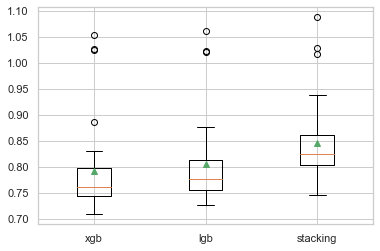

In [505]:
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## Model Selection

In [399]:
model_df={'Model_no' : [1,2,3,4,5,6,7,8],\
          'Train_RMSE': [MRSStrain1,MRSStrain2,MRSStrain3,MRSStrain4,MRSStrain5,MRSStrain6,MRSStrain7,MRSStrain8],\
         'Val_RMSE': [MRSSval1,MRSSval2,MRSSval3,MRSSval4,MRSSval5,MRSSval6,MRSSval7,MRSSval8]}

In [411]:
df=pd.DataFrame(model_df)
df.set_index('Model_no',inplace = True)

Text(0, 0.5, 'Root Mean Squared Error')

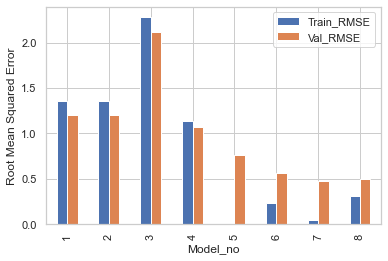

In [413]:

df.plot(kind='bar')
plt.ylabel("Root Mean Squared Error")

### Tuning Best Model

In [143]:


importance = dt.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

NameError: name 'dt' is not defined